In [1]:
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/home/Yan-Cheng-Hsu/anaconda3/envs/test/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model , Sequential
from keras.layers import Input, LSTM , Bidirectional , Dropout , Activation , Dense , Add , GRU , concatenate
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
from keras.models import load_model , save_model
import os
from scipy.stats import pearsonr

os.environ["CUDA_VISIBLE_DEVICES"] = ' 2 '

def rmse_loss (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

def mae_loss (y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))
    
lambda_mse = 10 # hyperparameter to be adjusted

def joint_loss (y_true, y_pred):
    rmse_loss = K.sqrt(K.mean(K.square(y_true - y_pred)))
    mae_loss = K.mean(K.abs(y_true - y_pred))
    
    return mae_loss + (lambda_mse * rmse_loss)



print('feature loading......')
features = np.load( '/data1/Yan-Cheng-Hsu/TimeSeriesFeatures/TDFE_20200601/TDFE_20200601_32i_Features.npy' , allow_pickle = True )
bp = np.load( '/data1/Yan-Cheng-Hsu/TimeSeriesFeatures/TDFE_20200601/TDFE_20200601_32i_BP.npy' , allow_pickle = True )


print( 'feature loading finished.' )




print( 'Preprocessing......' )

RawFeatures = []
RawBP = []
Features = []
BP = []
maxList = []
minList = []
avgList = []

for x in range( len(bp) ):
    zerol = []
    for i in range( len(bp[x]) ):
        if bp[x][i][1] == 0:
            zerol.append( i )
            
    if len(zerol) != 0 :  
        
        if ( zerol[0] == 0 ) and ( zerol[ len(zerol)-1 ] == ( len(bp[x])-1 ) ) :
            for i in range( 1 , len(zerol) , 1 ):
                tempf = features[x][ (zerol[i-1]+1) : zerol[i] ]
                tempb = bp[x][ (zerol[i-1]+1) : zerol[i] ]
                if( len(tempb) != 0 ):
                    RawFeatures.append( tempf )
                    RawBP.append( tempb )
        elif ( zerol[0] == 0 ) and ( zerol[ len(zerol)-1 ] != ( len(bp[x])-1 ) ) :
            for i in range( 1 , len(zerol) , 1 ):
                tempf = features[x][ (zerol[i-1]+1) : zerol[i] ]
                tempb = bp[x][ (zerol[i-1]+1) : zerol[i] ]
                if( len(tempb) != 0 ):
                    RawFeatures.append( tempf )
                    RawBP.append( tempb )
            tempf = features[x][ (zerol[len(zerol)-1])+1 : len(features[x])-1 ]
            tempb = bp[x][ (zerol[len(zerol)-1])+1 : len(bp[x])-1 ]
            if( len(tempb) != 0 ):
                RawFeatures.append( tempf )
                RawBP.append( tempb )
        elif ( zerol[0] != 0 ) and ( zerol[ len(zerol)-1 ] == ( len(bp[x])-1 ) ) :
            tempf = features[x][ 0 : zerol[0] ]
            tempb = bp[x][ 0 : zerol[0] ]
            if( len(tempb) != 0 ) :
                RawFeatures.append( tempf )
                RawBP.append( tempb )
            for i in range( 1 , len(zerol) , 1 ):
                tempf = features[x][ (zerol[i-1]+1) : zerol[i] ]
                tempb = bp[x][ (zerol[i-1]+1) : zerol[i] ]
                if( len(tempb) != 0 ) :
                    RawFeatures.append( tempf )
                    RawBP.append( tempb )
        else :
            tempf = features[x][ 0 : zerol[0] ]
            tempb = bp[x][ 0 : zerol[0] ]
            if( len(tempb) != 0 ):
                RawFeatures.append( tempf )
                RawBP.append( tempb )
            for i in range( 1 , len(zerol) , 1 ):
                tempf = features[x][ (zerol[i-1]+1) : zerol[i] ]
                tempb = bp[x][ (zerol[i-1]+1) : zerol[i] ]
                if( len(tempb) != 0 ) :
                    RawFeatures.append( tempf )
                    RawBP.append( tempb )
            tempf = features[x][ (zerol[len(zerol)-1])+1 : len(features[x])-1 ]
            tempb = bp[x][ (zerol[len(zerol)-1])+1 : len(bp[x])-1 ]
            if( len(tempb) != 0 ) :
                RawFeatures.append( tempf )
                RawBP.append( tempb )     
    else :
        if( len(bp[x]) != 0 ):
            RawFeatures.append( features[x] )
            RawBP.append( bp[x] )



for i in range( len(RawFeatures) ):

    if len(RawFeatures[i]) < 1:
        continue
    else:
        for j in range( 1 , len(RawFeatures[i]) , 1 ):
            Features.append( RawFeatures[i][j-1:j] )
            BP.append( RawBP[i][j-1:j] )
Features = np.array( Features )
BP = np.array( BP )


for i in range( len(Features) ):
    maxList.append( np.max( Features[i] , axis = 0 ) )
    minList.append( np.min( Features[i] , axis = 0 ) )
    avgList.append( np.mean( Features[i] , axis = 0 ) )
    

maxList = np.array( maxList )
minList = np.array( minList )
avgList = np.array( avgList )
    
maxArray = np.max( maxList , axis = 0 )
minArray = np.min( minList , axis = 0 )
avgArray = np.mean( avgList , axis = 0 )

for i in range( len(Features) ):
    Features[i] = ( Features[i] - avgArray ) / ( maxArray - minArray )


x_train , x_test , y_train , y_test = train_test_split( Features , BP , test_size = 0.2 )


X_train = np.ndarray( ( len(x_train) , 1 , 32 ), dtype=float)
for i in range( len(x_train) ):
    X_train[i] = x_train[i]
X_test = np.ndarray( ( len(x_test) , 1 , 32 ), dtype=float)
for i in range( len(x_test) ):
    X_test[i] = x_test[i]
Y_train = np.ndarray( ( len(y_train) , 1 , 2 ), dtype=float)
for i in range( len(y_train) ):
    Y_train[i] = y_train[i]
Y_test = np.ndarray( ( len(y_test) , 1 , 2 ), dtype=float)
for i in range( len(y_test) ):
    Y_test[i] = y_test[i]




print( 'Preprocessing finished.' )

Using TensorFlow backend.


feature loading......
feature loading finished.
Preprocessing......
Preprocessing finished.


In [3]:
model_path = '/home/Yan-Cheng-Hsu/PaperPublication/best.h5'
loadModel = load_model( model_path , custom_objects = { 'rmse_loss' : rmse_loss , 'joint_loss' : joint_loss , 'mae_loss' : mae_loss })
loadModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 32)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 2048)           67584     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2048)           0         
_________________________________________________________________
activation_1 (Activation)    (None, 1, 2048)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 4096)           8392704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 4096)           0         
_________________________________________________________________
activation_2 (Activation)    (None, 1, 4096)           0   

In [4]:
f = np.ndarray( (X_train.shape[0]+X_test.shape[0] , 1 , 32) , dtype = float )
bp = np.ndarray( (Y_train.shape[0]+Y_test.shape[0] , 1 , 2) , dtype = float )
for i in range( X_train.shape[0] ):
    f[i] = X_train[i]
for i in range( X_test.shape[0] ):
    f[i+X_train.shape[0]] = X_test[i]

for i in range( Y_train.shape[0] ):
    bp[i] = Y_train[i]
for i in range( Y_test.shape[0] ):
    bp[i+Y_train.shape[0]] = Y_test[i]
print( loadModel.evaluate( f , bp ) )

2176188/2176188 [==============================] - 156s 72us/step
[42.173696005904034, 3.9451069831848145, 2.7228102684020996]


In [5]:
a = loadModel.predict( f )
e_sbp = []
e_dbp = []
t_sbp = []
t_dbp = []
for i in range( len(a) ):
    e_sbp.append( a[i][0][0] )
    e_dbp.append( a[i][0][1] )
    t_sbp.append( bp[i][0][0] )
    t_dbp.append( bp[i][0][1] )

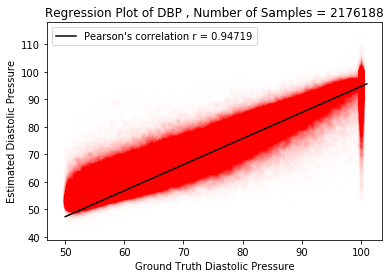

In [6]:
x = np.linspace( 50 , 101 , 52 )
r = pearsonr( t_dbp , e_dbp )
plt.plot( x , x*r[0] , color = 'black' , label = "Pearson's correlation r = " + str( round( r[0] , 6 ) ) )
plt.scatter( t_dbp , e_dbp , color = 'red' , marker = '*' , alpha = 1/255 )
plt.xlabel( 'Ground Truth Diastolic Pressure' )
plt.ylabel( 'Estimated Diastolic Pressure' )
plt.title( 'Regression Plot of DBP , Number of Samples = ' + str(bp.shape[0]) )
#plt.savefig( '/home/Yan-Cheng-Hsu/PaperPublication/dbp_regression_plot.png' )
plt.legend( loc = 'best' )
plt.show()

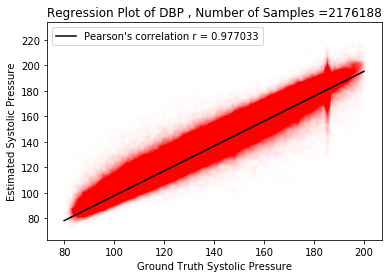

In [7]:
x = np.linspace( 80 , 200 , 200 )
r = pearsonr( t_sbp , e_sbp )
plt.plot( x , x*r[0] , color = 'black' , label = "Pearson's correlation r = " + str( round( r[0] , 6 ) ) )
plt.scatter( t_sbp , e_sbp , color = 'red' , marker = '*' , alpha = 1/255 )
plt.xlabel( 'Ground Truth Systolic Pressure' )
plt.ylabel( 'Estimated Systolic Pressure' )
plt.title( 'Regression Plot of DBP , Number of Samples =' + str(bp.shape[0]) )
#plt.savefig( '/home/Yan-Cheng-Hsu/PaperPublication/sbp_regression_plot.png' )
plt.legend( loc = 'best' )
plt.show()

In [8]:
t_sbp = np.array( t_sbp )
e_sbp = np.array( e_sbp )
t_dbp = np.array( t_dbp )
e_dbp = np.array( e_dbp )
err_sbp = np.sort( np.round( t_sbp - e_sbp , 1) , kind = 'heapsort' )
err_dbp = np.sort( np.round( t_dbp - e_dbp , 1) , kind = 'heapsort' )

In [9]:
L = [ 'SBP' , 'DBP' ]
Att = {}
Att['SBP'] = err_sbp
Att['DBP'] = err_dbp
x = {}
y = {}
for index in L:
    x[ index ] = []
    y[ index ] = []
    x[ index ].append( Att[ index ][0] )
    y[ index ].append( 1 )
    j = 0
    for i in range( 1 , len(Att[ index ]) , 1 ):
        if Att[ index ][i] == x[ index ][j]:
            y[ index ][j] = y[ index ][j] + 1
        else:
            x[ index ].append( Att[ index ][i] )
            y[ index ].append( 1 )
            j = j + 1
    for i in range( len(x[ index ]) ):
        x[ index ][i] = str( x[ index ] [i])

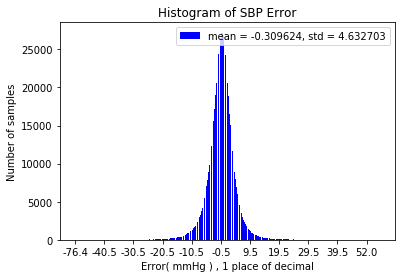

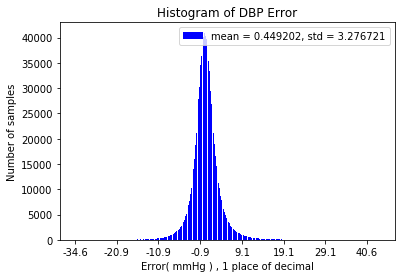

In [10]:
for i in L:
    plt.bar( x[i] , y[i] , color = 'blue' , label = 'mean = '  + str( np.round( np.mean(Att[i]) , 6 ) ) + ', std = ' + str( np.round( np.std(Att[i]) , 6 ) ) )
    plt.xlabel( 'Error( mmHg ) , 1 place of decimal' )
    plt.ylabel( 'Number of samples' )
    plt.xticks( x[i][0::100] )
    plt.title( 'Histogram of ' + i + ' Error' )
    #plt.savefig( '/home/Yan-Cheng-Hsu/PaperPublication/' + i +'_Error_histogram.png' )
    plt.legend( loc = 'best' )
    plt.show()    

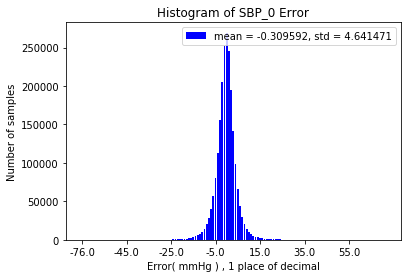

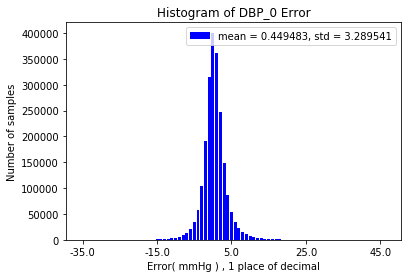

In [14]:
t_sbp = np.array( t_sbp )
e_sbp = np.array( e_sbp )
t_dbp = np.array( t_dbp )
e_dbp = np.array( e_dbp )
err_sbp = np.sort( np.around( t_sbp - e_sbp , 0) , kind = 'heapsort' )
err_dbp = np.sort( np.around( t_dbp - e_dbp , 0) , kind = 'heapsort' )
L = [ 'SBP_0' , 'DBP_0' ]
Att = {}
Att['SBP_0'] = err_sbp
Att['DBP_0'] = err_dbp
x = {}
y = {}
for index in L:
    x[ index ] = []
    y[ index ] = []
    x[ index ].append( Att[ index ][0] )
    y[ index ].append( 1 )
    j = 0
    for i in range( 1 , len(Att[ index ]) , 1 ):
        if Att[ index ][i] == x[ index ][j]:
            y[ index ][j] = y[ index ][j] + 1
        else:
            x[ index ].append( Att[ index ][i] )
            y[ index ].append( 1 )
            j = j + 1
    for i in range( len(x[ index ]) ):
        x[ index ][i] = str( x[ index ] [i])

        
for i in L:
    plt.bar( x[i] , y[i] , color = 'blue' , label = 'mean = '  + str( np.round( np.mean(Att[i]) , 6 ) ) + ', std = ' + str( np.round( np.std(Att[i]) , 6 ) ) )
    plt.xlabel( 'Error( mmHg ) , 1 place of decimal' )
    plt.ylabel( 'Number of samples' )
    plt.xticks( x[i][0::20] )
    plt.title( 'Histogram of ' + i + ' Error' )
    plt.savefig( '/home/Yan-Cheng-Hsu/PaperPublication/' + i +'_Error_histogram.png' )
    plt.legend( loc = 'best' )
    plt.show()  

In [36]:
t_sbp = np.array( t_sbp )
e_sbp = np.array( e_sbp )
t_dbp = np.array( t_dbp )
e_dbp = np.array( e_dbp )
err_sbp = np.sort( np.around( t_sbp - e_sbp , 0) , kind = 'heapsort' )
err_dbp = np.sort( np.around( t_dbp - e_dbp , 0) , kind = 'heapsort' )
L = [ 'SBP' , 'DBP' ]
Att = {}
Att['SBP'] = err_sbp
Att['DBP'] = err_dbp

In [38]:
x = {}
y = {}
x['SBP'] = [i for i in range( -80 , 86 ,5)]
x['DBP'] = [i for i in range( -35 , 51 ,5)]
y['SBP'] = err_sbp
y['DBP'] = err_dbp

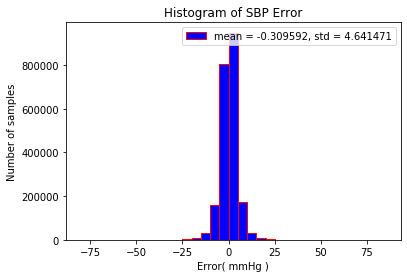

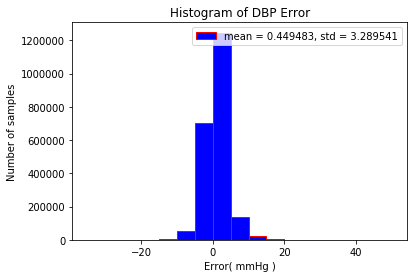

In [41]:
for i in L:
    plt.hist(  y[i] , bins = x[i] , color = 'blue' , edgecolor = 'red' , label = 'mean = '  + str( np.round( np.mean(Att[i]) , 6 ) ) + ', std = ' + str( np.round( np.std(Att[i]) , 6 ) ) )
    plt.xlabel( 'Error( mmHg )' )
    plt.ylabel( 'Number of samples' )
    plt.title( 'Histogram of ' + i + ' Error' )
    plt.savefig( '/home/Yan-Cheng-Hsu/PaperPublication/' + i +'_Error_histogram.png' )
    plt.legend( loc = 'best' )
    plt.show()  